# Import Libraries

In [510]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from pandas.plotting import scatter_matrix
import sys
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error

% matplotlib inline

print('Python version', sys.version)
print('Pandas version', pd.__version__)
print('Numpy version', np.__version__)

Python version 3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version 0.20.3
Numpy version 1.14.0


# Setup

## Import Data

In [486]:
features = pd.read_pickle('../data/feature_data.pkl')
target = pd.read_pickle('../data/target_data.pkl')

Drop rows with any null values

In [487]:
def clean_nans(feat, tar):
    """
    Make sure there aren't any rows with nan values
    """
    nan_index = pd.isnull(feat).any(1).nonzero()[0]
    
    if len(nan_index):
        feat.dropna(axis=0, how='any', inplace=True)
        feat.reset_index(drop=True, inplace=True)
        
        tar.drop(target.index[nan_index], inplace=True)
        tar.reset_index(drop=True, inplace=True)
        
    return feat, tar

In [488]:
features, target = clean_nans(features, target)

## Define Evaluation Metrics

In [556]:
class Stats:
    
    def __init__(self, X, y, model):
        self.data = X
        self.target = y
        self.model = model
        ## degrees of freedom population dep. variable variance
        self._dft = X.shape[0] - 1   
        ## degrees of freedom population error variance
        self._dfe = X.shape[0] - X.shape[1] - 1  
        
    def sse(self):
        '''returns sum of squared errors (model vs actual)'''
        squared_errors = (self.target - self.model.predict(self.data)) ** 2
        return np.sum(squared_errors)

    def sst(self):
        '''returns total sum of squared errors (actual vs avg(actual))'''
        avg_y = np.mean(self.target)
        squared_errors = (self.target - avg_y) ** 2
        return np.sum(squared_errors)
    
    def r_squared(self):
        '''returns calculated value of r^2'''
        return 1 - self.sse()/self.sst()
    
    def adj_r_squared(self):
        '''returns calculated value of adjusted r^2'''
        return 1 - (self.sse()/self._dfe) / (self.sst()/self._dft)
    
    def rmse(self):
        '''returns the root mean squared error'''
        mse = mean_squared_error(self.target, self.model.predict(self.data))
        return np.sqrt(mse)



In [574]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''

    stats = Stats(X_train, y_train, model)
    rmse = stats.rmse()
    adj_r_sqr = stats.adj_r_squared()
    
    return rmse, adj_r_sqr 
    
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    
    stats = Stats(X_test, y_test, model)
    rmse = stats.rmse()
    adj_r_sqr = stats.adj_r_squared()
    
    return rmse, adj_r_sqr 
    
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)

    train_rmse, train_adj_r = calc_train_error(X_train, y_train, model)
    validation_rmse, validation_adj_r = calc_validation_error(X_test, y_test, model)
            
    return train_rmse, train_adj_r, validation_rmse, validation_adj_r

In [568]:
def pretty_print_stats(train_rmse, train_adj_r, validation_rmse, validation_adj_r):
    '''returns report of statistics for a given model object'''
    
    adj_r = ( ('Training :', train_adj_r), ('Validation :', validation_adj_r) )
    rmse = ( ('Training :', train_rmse), ('Validation :', validation_rmse) )
    
    print('Adjusted R^2')
    for item in adj_r:
        print('{0:12} {1:.4f}'.format(item[0], item[1]))
      
    print('')
        
    print('RMSE')
    for item in rmse:
        print('{0:12} {1:.4f}'.format(item[0], item[1]))

## Define Cross Validation Function

In [575]:
def cross_validation_kfold(features, target, num_folds, model):
    """
    Takes in feature set, target, model and number of folds to evaluate the in and out of sample error
    Returns the train and validation errors
    """
    K = num_folds
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    
    if len(np.shape(features))==1:
        features = pd.DataFrame(np.array(features).reshape(-1,1))

    # Initialize lists for capturing error terms at each fold of training and validation sets
    train_rmse_l = []
    train_adj_r_l = []
    validation_rmse_l = []
    validation_adj_r_l = []
    
    for train_index, val_index in kf.split(features, target):
        
        # split data
        X_train, X_val = features.loc[train_index], features.loc[val_index]
        y_train, y_val = target[train_index], target[val_index]
        
        # scale data
        scaler = preprocessing.RobustScaler()
        sc_X_train = scaler.fit_transform(X_train)
        sc_X_val = scaler.transform(X_val)

        # calculate errors
        train_rmse, train_adj_r, validation_rmse, validation_adj_r = calc_metrics(X_train = sc_X_train, 
                                                                                  y_train = y_train, 
                                                                                  X_test = sc_X_val, 
                                                                                  y_test = y_val, 
                                                                                  model = model)


        # append to appropriate list
        train_rmse_l.append(train_rmse)
        train_adj_r_l.append(train_adj_r)
        validation_rmse_l.append(validation_rmse)
        validation_adj_r_l.append(validation_adj_r)
        
        
    # generate report    
    pretty_print_stats(train_rmse=np.mean(train_rmse_l), 
                       train_adj_r=np.mean(train_adj_r_l), 
                       validation_rmse=np.mean(validation_rmse_l), 
                       validation_adj_r=np.mean(validation_adj_r_l))
              

## Define Plotting Functions

In [630]:
def plot_predictions(x, y, model_obj):
    """
    Takes in features, target and a model object and returns plot of cross val predictions
    """
    model_obj.fit(x, y)
    predicted = model_obj.predict(x)

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.scatter(predicted, y, edgecolors=(0, 0, 0), alpha=.5, color='blue')
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    
    ax.set_title('Actual Target by Predicted Target', size=20)
    ax.set_xlabel('Predicted Target', size=12)
    ax.set_ylabel('Actual Target', size=12)
    
    plt.show();

In [631]:
def plot_residuals(x, y, model_obj):
    
    model_obj.fit(x, y)
    
    predictions = model_obj.predict(x)
    residuals_linear = y - predictions
    
    fig, ax = plt.subplots(figsize=(7,4))
    plt.plot(predictions, residuals_linear, 'bo', alpha=.5, color='r')
    plt.axhline(y=0, color='k')
    plt.grid()
    
    ax.set_title('Residuals by Predicted Target', size=20)
    ax.set_xlabel('Predicted Target', size=12)
    ax.set_ylabel('Residuals', size=12)

    plt.show;

# Model Testing

## Review Correlations

Let's revisit our features to find the most correlated feature so we can start there

In [632]:
target_features = pd.concat([target, features], axis=1)

In [633]:
def fancy_corr(corr):
    cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
    
    return corr.style.background_gradient(cmap, axis=1)\
            .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
            .set_precision(2)

In [634]:
fancy_corr(target_features.corr())


,Graduation_Rate_School,Average_ACT_School,crimes_per_student,dollars_per_student,percent_diff_budget,percent_low_income,is_selective_enroll,Average_ACT_log,crimes_student_log,dollars_student_log
Graduation_Rate_School,1,0.7,-0.51,-0.34,-0.0071,-0.45,0.41,0.74,-0.54,-0.39
Average_ACT_School,0.7,1,-0.44,-0.43,0.091,-0.83,0.7,0.99,-0.53,-0.48
crimes_per_student,-0.51,-0.44,1,0.56,0.0063,0.35,-0.21,-0.48,0.85,0.53
dollars_per_student,-0.34,-0.43,0.56,1,0.17,0.34,-0.28,-0.45,0.51,0.95
percent_diff_budget,-0.0071,0.091,0.0063,0.17,1,-0.11,-0.045,0.11,-0.12,0.2
percent_low_income,-0.45,-0.83,0.35,0.34,-0.11,1,-0.59,-0.81,0.49,0.36
is_selective_enroll,0.41,0.7,-0.21,-0.28,-0.045,-0.59,1,0.66,-0.25,-0.31
Average_ACT_log,0.74,0.99,-0.48,-0.45,0.11,-0.81,0.66,1,-0.56,-0.5
crimes_student_log,-0.54,-0.53,0.85,0.51,-0.12,0.49,-0.25,-0.56,1,0.49
dollars_student_log,-0.39,-0.48,0.53,0.95,0.2,0.36,-0.31,-0.5,0.49,1


Ok, so let's start with a simple univariate model on the **Average ACT log** feature

In [635]:
lr = LinearRegression(fit_intercept=True)

## Feature Selection Using Cross Validation

In [636]:
def test_new_model(feature_set, target, model=lr, num_folds=7):
    """
    Takes in new feature set or model to evaluate in cross validation
    """
    print('Graduation Rates by {} \n'.format(list(feature_set.columns)))

    cross_validation_kfold(features=feature_set,
                              target=target,
                              num_folds=num_folds,
                              model=model)
        
    plot_residuals(x=feature_set, y=target, model_obj=model)
    
    plot_predictions(x=feature_set, y=target, model_obj=model)
    

#### Average ACT

Graduation Rates by ['Average_ACT_log'] 

Adjusted R^2
Training :   0.5384
Validation : 0.4675

RMSE
Training :   9.1540
Validation : 9.1778


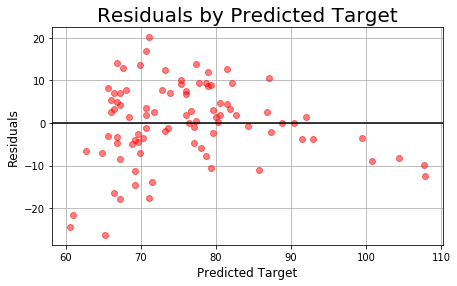

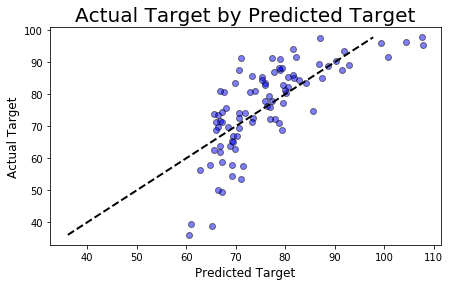

In [637]:
feature_set = features.filter(['Average_ACT_log'], axis=1)
test_new_model(feature_set, target)

This R squared isn't much better than random chance... but the in and out of sample error are pretty close together. If I have high error but my low variance between the two samples I can conclude that my model is **underfitting the data**

Let's see if we can improve this by adding another feature - I'll add the **Crimes per Student Log** feature next

#### Average ACT & Crime

Graduation Rates by ['Average_ACT_log', 'crimes_student_log'] 

Adjusted R^2
Training :   0.5552
Validation : 0.4419

RMSE
Training :   8.9266
Validation : 8.9473


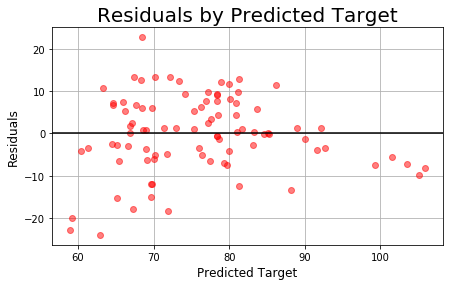

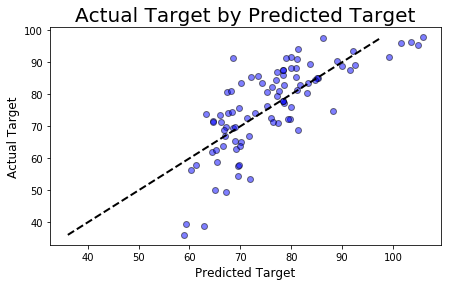

In [638]:
feature_set = features.filter(['Average_ACT_log', 'crimes_student_log'], axis=1)
test_new_model(feature_set, target)

I see my adjusted R square bump up just slightly and my root mean square error decrease but the variance between the two sets is also increasing. Let's try adding another term to see what happens

#### Average ACT & Crime & Selective Enrollment

Graduation Rates by ['Average_ACT_log', 'crimes_student_log', 'is_selective_enroll'] 

Adjusted R^2
Training :   0.5553
Validation : 0.3787

RMSE
Training :   8.8647
Validation : 8.9442


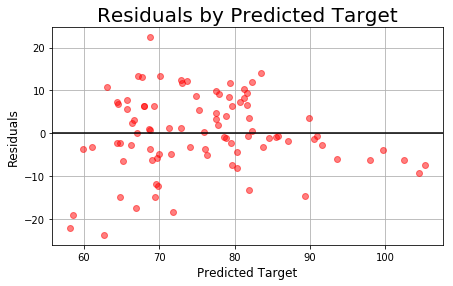

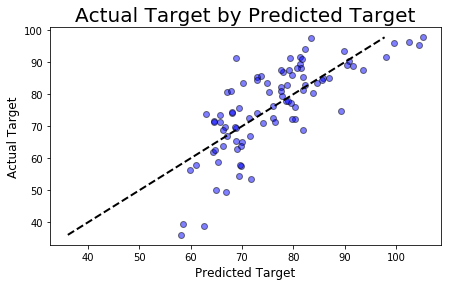

In [639]:
feature_set = features.filter(['Average_ACT_log', 
                                     'crimes_student_log', 
                                     'is_selective_enroll'], axis=1)
test_new_model(feature_set, target)

#### Average ACT & Crime & percent_low_income

Graduation Rates by ['Average_ACT_log', 'crimes_student_log', 'percent_low_income'] 

Adjusted R^2
Training :   0.6163
Validation : 0.4606

RMSE
Training :   8.2358
Validation : 8.4151


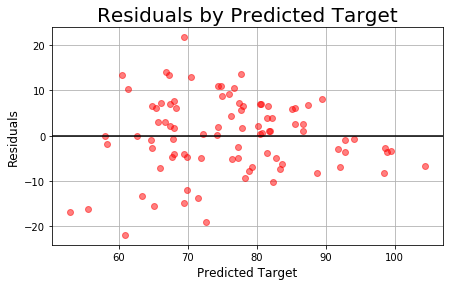

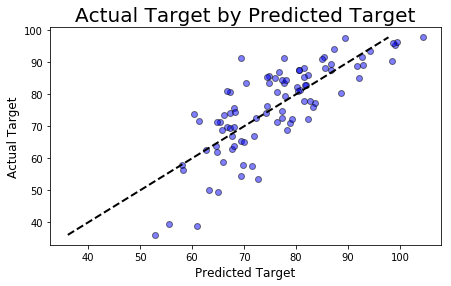

In [640]:
feature_set = features.filter(['Average_ACT_log', 
                                 'crimes_student_log', 
                                 'percent_low_income'], axis=1)
test_new_model(feature_set, target)

#### Average ACT and dollars_student_log

Graduation Rates by ['Average_ACT_log', 'dollars_student_log'] 

Adjusted R^2
Training :   0.5331
Validation : 0.4057

RMSE
Training :   9.1453
Validation : 9.2374


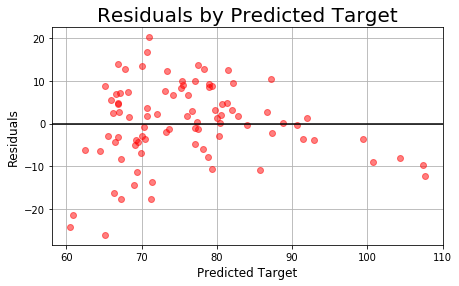

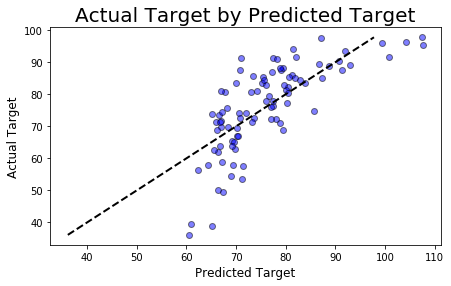

In [641]:
feature_set = features.filter(['Average_ACT_log', 'dollars_student_log'], axis=1)
test_new_model(feature_set, target)

Yikes!! The dollars per student feature drives my error above what it is with Average ACT log alone - I'm going to go back and add the rows of data I threw away after I wasn't able to resolve all the budget data